<a id='top'></a>

# CSCI 3202, Spring 2020
# Assignment 2
# Due: Friday 14 February 2020 by 11:59 PM

<br>

### Your name: Alex Book

<br>







## Problem 1 (25 points)

### Escape from Chicago

It is the year 2030 and a freak earthquake has caused Chicago to break off from the mainland of Illinois. It has drifted out into Lake Michigan and is now used as a penal colony for the United States' worst criminals.  Snake Plisskin, world-famous tough guy and amateur sea lion enthusiast, must travel from Chicago to New York to find the antidote to the *Plutoxin 7 poison* that he and many other Chicagoans have been infected with.

Below are crude graphs, representing the northeastern United States.  The graph on the left, **map_distances**, represents the step costs between two states on the graph (cities) using the distance between the two cities along major highways.  On the right, **map_times** represents the step costs using estimated travel time (at 5 PM on a Friday, east coast time).  These graphs are defined in the helper routines at below.

If you take a look at those graphs, you will notice that for brevity's sake, we will use **lowercase** abbreviations for each city, consisting of the **first 3 letters** of the city's name.  So Providence is represented by the state 'pro', for example.

### Helper imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from collections import deque
import heapq
import unittest
from scipy import stats

**map_distances**          |  **map_times**
:-------------------------:|:-------------------------:
<img src="http://drive.google.com/uc?export=view&id=1j6Kam3F7ET-aIzT-6KMxaW7D7r8WAOME" alt="Drawing" style="width: 550px;"/>  | <img src="http://drive.google.com/uc?export=view&id=1rI5w8CuWOS9reMIewc2IDBp_Z3pSUu1H" alt="Drawing" style="width: 550px;"/>

### Useful helper routines for searching

In [2]:
def path(previous, s): 
    '''
    `previous` is a dictionary chaining together the predecessor state that led to each state
    `s` will be None for the initial state
    otherwise, start from the last state `s` and recursively trace `previous` back to the initial state,
    constructing a list of states visited as we go
    '''
    if s is None:
        return []
    else:
        return path(previous, previous[s])+[s]

def pathcost(path, step_costs):
    '''
    add up the step costs along a path, which is assumed to be a list output from the `path` function above
    '''
    cost = 0
    for s in range(len(path)-1):
        cost += step_costs[path[s]][path[s+1]]
    return cost

In [3]:
map_distances = dict(
    chi=dict(det=283, cle=345, ind=182),
    cle=dict(chi=345, det=169, col=144, pit=134, buf=189),
    ind=dict(chi=182, col=176),
    col=dict(ind=176, cle=144, pit=185),
    det=dict(chi=283, cle=169, buf=256),
    buf=dict(det=256, cle=189, pit=215, syr=150),
    pit=dict(col=185, cle=134, buf=215, phi=305, bal=247),
    syr=dict(buf=150, phi=253, new=254, bos=312),
    bal=dict(phi=101, pit=247),
    phi=dict(pit=305, bal=101, syr=253, new=97),
    new=dict(syr=254, phi=97, bos=215, pro=181),
    pro=dict(bos=50, new=181),
    bos=dict(pro=50, new=215, syr=312, por=107),
    por=dict(bos=107))

map_times = dict(
    chi=dict(det=280, cle=345, ind=200),
    cle=dict(chi=345, det=170, col=155, pit=145, buf=185),
    ind=dict(chi=200, col=175),
    col=dict(ind=175, cle=155, pit=185),
    det=dict(chi=280, cle=170, buf=270),
    buf=dict(det=270, cle=185, pit=215, syr=145),
    pit=dict(col=185, cle=145, buf=215, phi=305, bal=255),
    syr=dict(buf=145, phi=245, new=260, bos=290),
    bal=dict(phi=145, pit=255),
    phi=dict(pit=305, bal=145, syr=245, new=150),
    new=dict(syr=260, phi=150, bos=270, pro=260),
    pro=dict(bos=90, new=260),
    bos=dict(pro=90, new=270, syr=290, por=120),
    por=dict(bos=120))

sld_providence = dict(
    chi=833,
    cle=531,
    ind=782,
    col=618,
    det=596,
    buf=385,
    pit=458,
    syr=253,
    bal=325,
    phi=236,
    new=157,
    pro=0,
    bos=38,
    por=136)

def check_map(step_costs):
    ''' function to check if all the path costs are at least symmetric '''
    check_states = []
    for state1 in step_costs.keys():
        for state2 in step_costs[state1].keys():
            uh_oh = step_costs[state2][state1]!=step_costs[state1][state2]
            if uh_oh:
                print('Check the costs between states {} and {}'.format(state1,state2))
                check_states.append([state1,state2])
    if len(check_states)==0:
        print('all okay! (symmetric at least)')
    return check_states

<a id='p1a'></a>
### (1a)

#### Breadth-first search

Implement a function **breadth_first(start, goal, state_graph, return_cost)** to search the state space (and step costs) defined by **state_graph** using breadth-first search:
* **start**: initial state (e.g., 'ind')
* **end**: goal state (e.g., 'bos')
* **state_graph**: the dictionary defining the step costs (e.g., `map_distances`)
* **return_cost**: logical input representing whether or not to return the solution path cost
  * If **True**, then the output should be a tuple where the first value is the list representing the solution path and the second value is the path cost
  * If **False**, then the only output is the solution path list object

Note that in the helper functions, two useful routines for obtaining your solution path are provided (and can be used for all the search algorithms):
  * **path(previous, s)**: returns a list representing a path to state **s**, where **previous** is a dictionary that maps predecessors (values) to successors (keys)
  * **pathcost(path, step_costs)**: adds up the step costs defined by the **step_costs** graph (e.g., `map_distances`) along the list of states **path**

In [4]:
# Your code here.
def breadth_first(start, goal, state_graph, return_cost):
    visited = {}
    previous = {}
    
    for i in state_graph:
        visited[i] = False
    
    queue = []
    queue.append(start)
    
    visited[start] = True
    previous[start] = None
    
    while queue:
        curr = queue.pop(0)
        if curr == goal and return_cost == True:
            curr_path = path(previous, goal)
            curr_cost = pathcost(curr_path, state_graph)
            return curr_path, curr_cost
        elif curr == goal and return_cost == False:
            curr_path = path(previous, goal)
            return curr_path
        else:
            for i in state_graph[curr]:
                if visited[i] == False:
                    queue.append(i)
                    visited[i] = True
                    previous[i] = curr

In [5]:
print(breadth_first("chi", "new", map_distances, True))

(['chi', 'det', 'buf', 'syr', 'new'], 943)


<a id='p1b'></a>
### (1b)

#### Depth-first search

Implement a function **depth_first(start, goal, state_graph, return_cost)** to search the state space (and step costs) defined by **state_graph** using depth-first search:
* **start**: initial state (e.g., 'ind')
* **end**: goal state (e.g., 'bos')
* **state_graph**: the dictionary defining the step costs (e.g., `map_distances`)
* **return_cost**: logical input representing whether or not to return the solution path cost
    * If **True**, then the output should be a tuple where the first value is the list representing the solution path and the second value is the path cost
    * If **False**, then the only output is the solution path list object

In [6]:
# Your code here.
def depth_first(start, goal, state_graph, return_cost):
    visited = {}
    prev = {start:None}
    
    for i in state_graph:
        visited[i] = False
    
    queue = []
    queue.append(start)
    
    visited[start] = True
    
    while queue:
        curr = queue.pop()
        if curr == goal:
            curr_path = path(prev, goal)
            curr_cost = pathcost(curr_path, state_graph)
            return (curr_path, curr_cost) if return_cost == True else curr_path
        else:
            for i in state_graph[curr]:
                if visited[i] == False:
                    queue.append(i)
                    visited[i] = True
                    prev[i] = curr

In [7]:
print(depth_first("chi", "new", map_distances, True))

(['chi', 'ind', 'col', 'pit', 'phi', 'new'], 945)


<a id='p1c'></a>
### (1c)

#### Uniform-cost search

First, let's create our own `Frontier_PQ` class to represent the frontier (priority queue) for uniform-cost search.  Note that the `heapq` package is imported in the helpers at the top of this notebook; you may find that package useful.  You could also use the `Queue` package.  Your implementation of the uniform-cost search frontier should adhere to these specifications:
* Instantiation arguments: 
  * **Frontier_PQ(start, cost)**
  * **start** is the initial state (e.g., **start**='chi')
  * **cost** is the initial path cost (what should it be for the initial state?)
* Instantiation attributes/methods:
  * **states**: maintains a dictionary of states on the frontier, along with the _minimum_ path cost to arrive at them
  * **q**: a list of (cost, state) tuples, representing the elements on the frontier; should be treated as a priority queue (in contrast to the **states** dictionary, which is meant to keep track of the lowest-cost to each state)
  * appropriately initialize the starting state and cost
* Methods to implement:
  * **add(state, cost)**: add the (cost, state) tuple to the frontier
  * **pop()**: return the lowest-cost (cost, state) tuple, and pop it off the frontier
  * **replace(state, cost)**: if you find a lower-cost path to a state that's already on the frontier, it should be replaced using this method.
  
Note that there is some redundancy between the information stored in **states** and **q**. I only suggest to code it in this way because I think it's the most straightforward way to get something working. You could reduce the storage requirements by eliminating the redundancy, but it increases the time complexity because of the function calls needed to manipulate your priority queue to check for states (since that isn't how the frontier queue is ordered).

In [8]:
# Your code here.
class Frontier_PQ():
    def __init__(self, start, cost = 0):
        self.start = start
        self.cost = cost
        self.states = {start:cost} # the explored nodes
        self.q = [[cost, start]] # the can-be-explored nodes
    
    def add(self,state,cost):
        self.states[state]=cost
        heapq.heappush(self.q,[cost,state])
    
    def pop(self):
        return heapq.heappop(self.q)
    
    def replace(self,state,cost):
        self.states[state]=cost
        for i,tup in enumerate(self.q):
            if tup[1]==state:
                self.q[i][0]=cost

Now, actually implement a function to search using `uniform_cost` search, called as **uniform_cost(start, goal, state_graph, return_cost)**:
* **start**: initial state
* **goal**: goal state
* **state_graph**: graph representing the connectivity and step costs of the state space (e.g., **map_distances** or **map_times** below)
* **return_cost**: logical input representing whether or not to return the solution path cost
  * If **True**, then the output should be a tuple where the first value is the list representing the solution path and the second value is the path cost
  * If **False**, then the only output is the solution path list object

In [9]:
# Your code here.
def uniform_cost(start, goal, state_graph, return_cost):
    frontier = Frontier_PQ(start)
    visited = set()
    prev = {start:None}
   
    while frontier.q:
        cost, curr = frontier.pop()
        if curr == goal:
            p = path(prev, curr)
            return (p, pathcost(p, state_graph)) if return_cost else p
        visited.add(curr)
       
        for adj in state_graph[curr]:
            if adj not in visited:
                if adj not in frontier.states:
                    prev[adj]=curr
                    frontier.add(adj,cost+state_graph[curr][adj])
                elif frontier.states[adj] > cost+state_graph[curr][adj]:
                    prev[adj]=curr
                    frontier.replace(adj,cost+state_graph[curr][adj])

<a id='p1d'></a>
### (1d)

In the code cell below, use a few **print** statements to showcase the output of each of your three search algorithms defined above (in **1a**, **1b** and **1c**) to find routes for Snake to travel from Chicago to New York, with path costs defined by the distance between cities.

Then, in the markdown cell below your code cell, write a few sentences:
* Which algorithm yields the shortest path?
* Why does this not surprise you?

In [10]:
# Your code here.
print(breadth_first("chi", "new", map_distances, True))
print(depth_first("chi", "new", map_distances, True))
print(uniform_cost("chi", "new", map_distances, True))

(['chi', 'det', 'buf', 'syr', 'new'], 943)
(['chi', 'ind', 'col', 'pit', 'phi', 'new'], 945)
(['chi', 'cle', 'pit', 'phi', 'new'], 881)


The uniform cost search yields the shortest path. This does not surprise me because it takes the the path costs into account when finding the path, whereas BFS and DFS don't.

<a id='p1e'></a>
### (1e)

The Plutoxin 7 poison (which Snake has been infected with) will cause Snake's central nervous system to implode after exactly 940 minutes.

Will any of the paths found in **(1d)** get Snake to New York alive?  Show your work! Snake's life hangs in the balance.

In [11]:
# Your code here.
print("Using BFS:", pathcost(['chi', 'det', 'buf', 'syr', 'new'], map_times))
print("Using DFS:", pathcost(['chi', 'ind', 'col', 'pit', 'phi', 'new'], map_times))
print("Using UCS:", pathcost(['chi', 'cle', 'pit', 'phi', 'new'], map_times))

Using BFS: 955
Using DFS: 1015
Using UCS: 945


Using the given **pathcost** function as well as the paths found in 1d, we get the above results, showing that Snake will not be able to get to New York alive using any of the above paths.

<a id='p1f'></a>
### (1f)

Since time is a factor, Snake ought to optimize his route from Chicago to New York to minimize the total time required. Because Snake is a renaissance man, he knows some pretty slick search algorithms.  But because he's infected with deadly poison, Snake just isn't up to the task of implementing them - his code is full of bugs and he keeps sneezing all over his monitor!  Let's help him out, shall we?

In the code cell below, find the shortest path from Chicago to New York as measured by total time taken, and display the result using a **print** statement

In the markdown cell below the code cell, write a couple of sentences:
* Why did you choose the search algorithm and state space graph that you chose?
* Would the solution path found by the other algorithms (the ones you didn't use in your function call) change if you tried to optimize based on time as opposed to distance (i.e., used **map_times** as opposed to **map_distances**)? Why or why not?
* **Most importantly:**  will Snake get to New York in time to receive the Plutoxin 7 antidote? This answer should be justified by your code output.

In [12]:
# Your code here.
print("Using UCS:", uniform_cost("chi", "new", map_times, True))

Using UCS: (['chi', 'cle', 'buf', 'syr', 'new'], 935)


I chose UCS because it takes into account the cost of each path using **map_times**, whereas BFS and DFS do not.

The solution paths found by the other algorithms (DFS and BFS) wouldn't change if you tried to optimize based on time as opposed to distance because neither of those methods take into account the path costs (edge weights).

As seen by the above output, Snake will make it to New York in time for the antidote (with 5 minutes to spare).


## Problem 2 (25 points)




<div>
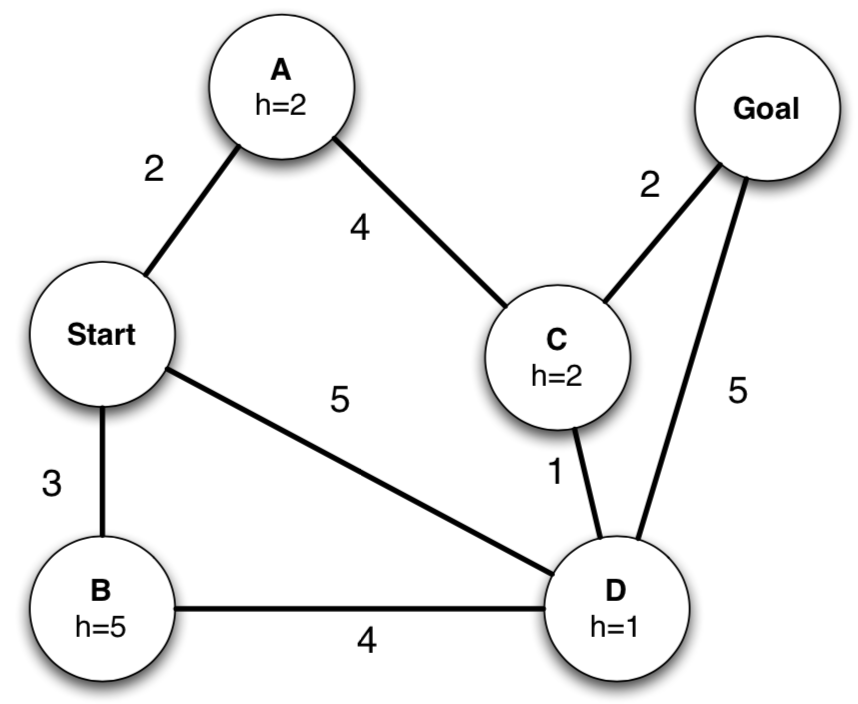
</div>

The graph above represents how long it takes the average student to walk between different parts of campus. For each of the following graph search strategies, work out the path returned by graph search. In all cases, assume ties resolve in such a way that states with earlier alphabetical order are expanded first. The start and goal state are S and G, respectively. Remember that in graph search, a state is expanded only once.

### (2a) 

Depth-First Search

**Note for grader for 2a-2d:** "previous" is simply my way of keeping track of the path in an easy-to-follow manner, whereas the actual functions written in question 1 would use the "path" function among other tools.

Path: S -> A -> C -> G

We first expand S, adding D,B,A to the stack with "previous" set to S, stacks is [D,B,A].

We then pop A and expand it, adding C to the stack with "previous" set to A, stack is [D,B,C].

We then pop C and expand it, adding G to the stack with "previous" set to C, stack is [D,B,G].

We then pop G, which is the goal, so we're done! We can follow the "previous" path from G to C to A to S, giving us a path of S-A-C-G.

### (2b) 

Breadth First Search

Path: S -> D -> G

We first expand S, adding A,B,D to the queue with "previous" set to S, the queue is [A,B,D].

We then pop A and expand it, adding C to the queue with "previous" set to A, the queue is [B,D,C].

We then pop B and expand it, adding nothing to the queue (D was already added), the queue is [D,C].

We then pop D and expand it, adding G to the queue with "previous" set to D, the queue is [C,G].

We then pop C and expand it, adding nothing to the queue (D and G were already added), the queue is [G].

We then pop G, which is the goal, so we're done! We can follow the "previous" path from G to D to S, giving us a path of S-D-G.

### (2c) 

Uniform-Cost Search

Path: S -> A -> C -> G

We first expand S, adding A,B,D to the priority queue (adding the respective edge costs to their previous costs of 0) with "previous" set to S, queue is [A,B,D].

We then pop A, adding C to the priority queue (adding A's cost and the A-C edge cost to C's previous cost of 0) with "previous set to A, queue is [B,D,C].

We then pop B, not replacing D in the priority queue as its previous cost was lower, queue is [D,C].

We then pop D, adding G to the priority queue (adding D's cost and the D-G edge cost to G's previous cost of 0) with "previous" set to D, but do not add C (as its previous cost is equal to this new cost, so there's no reason to replace it), queue is [C,G].

We then pop C, replacing G in the priority queue (as its previous cost going from D was 10, but S-A-C-G cost would be only 8) with "previous" reassigned to C, queue is [G].

We then pop G, which is the goal, so we're done! We can follow the "previous" path from G to C to A to S, giving us a path of S-A-C-G.

### (2d)  
A* search with the heuristic values listed at each state.

Path: S -> A -> C -> G

We first expand S, adding A,D,B to the priority queue (costs of 4,6,8 respectively) with "previous" set to S, queue is [A,D,B].

We then pop A, adding C (cost of 8) to the priority queue with "previous" set to A, queue is [D,B,C].

We then pop D, adding G (cost of 10) to the priority queue with "previous" set to D, queue is [B,C,G].

We then pop B, adding nothing to the priority queue (no cheaper costs for replacenment), queue is [C,G].

We then pop C, replacing G with a lower cost of 8 (compared to its previous cost of 10) with "previous" reassigned to C, queue is now [G].

We then pop G, which is the goal, so we're done! We can follow the "previous" path from G to C to A to S, giving us a path of S-A-C-G.

### (2e) 
Imagine a car-like agent (shown by the arrow shape below) wishing to reach the end of a long corridor like the one shown below. The agent cannot turn around and is always pointed (and driving) to the right. The agent's initial velocity is zero, but can move at the integer velocities in $[0, V]$. At each time step, the agent can either coast (not change velocity), accelerate (increase velocity by 1), or decelerate (decrease velocity by 1). Once an action is selected, the agent then moves a number of squares equal to its NEW adjusted velocity. For example, if the first action is to accelerate, the agent will end up one square to the right with a new velocity of 1. The agent's goal is to find a plan which parks it (at zero velocity) on the exit square using as few actions (time steps) as possible. Assume the agent begins in the leftmost square with velocity 0.

<div>
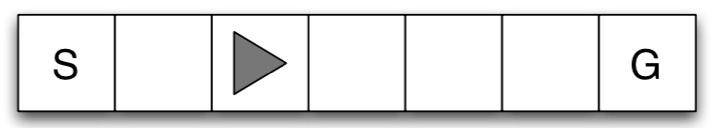
</div>

If the corridor is of length L, what is the size of the state space? Briefly justify your answer. You need not consider whether a state is actually reachable from the start state on this board.

L(V+1) because there are L tiles and V+1 velocities (as the possibilities for velocity are in an array from 0 to V).

### (2f) 
Still considering the image from **(2e)**, what is the maximum branching factor of this problem?

3 because each "node" has three possibilities (accelerate, coast, or slow down)

### (2g)
Again referencing **(2e)** Is the distance from the agent's location to the exit an admissible heuristic? Why or why not?

No, it is not admissible. Take, for example, the distance to the exit to be 5 and the velocity to be 2. The cost predicted by the distance to the exit is therefore 5. However, the optimal cost of 4 time steps can be achieved as follows:

1. Distance to exit is 5 and velocity is 2, choose to coast (travel 2 tiles)
2. Distance to exit is 3 and velocity is 2, choose to coast (travel 2 tiles)
3. Distance to exit is 1 and velocity is 2, choose to slow down to 1 (travel 1 tile)
4. Distance to exit is 0 and velocity is 1, choose to slow down 0 (travel 0 tiles, staying at the exit)

Therefore, distance over-predicted the cost to reach the goal, meaning that it is not an admissible heuristic.

### (2h)
State and justify a non-trivial, admissible heuristic for this problem (**(2e)**) which is not the distance to the exit.

A non-trivial, admissible heuristic for this problem would be distance/maximum velocity (distance to the exit divided by the maximum possible velocity), as such a value is non-trivial and is never an over-prediction of the time/cost needed to reach the exit.



## Problem 3 (25 points)

Consider this maze, where gray tiles represent walls and orange tiles represent open space where you can walk.

<img src="http://drive.google.com/uc?export=view&id=1bCT7aePAwB1t8ZdIboOqmhzMAQ_grKBZ" alt="Drawing" style="width: 200px;"/>

We can represent this maze using a binary `numpy` array as follows, where 1s represent walls and 0s represent open space:

In [13]:
maze = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                 [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
                 [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                 [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
                 [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
                 [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1],
                 [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1],
                 [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1],
                 [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1],
                 [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
                 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

**Very importantly**, note that the *first* row of the **maze** array corresponds to the *bottom* row of tiles in the figure.  This is a choice made carefully to reflect the fact that we are going to search for a solution path through this maze in *physical* space, so it is useful for our coordinate system to match Cartesian coordinates. This is in contrast to using the first row of the **maze** array to represent the top of the maze, which looks intuitive.

<a id='p3a'></a>
### (3a)

Write a function **maze_to_graph(maze)** that:
* takes as input a binary maze **maze**, stored as a `numpy` array, where 0 represents an open path and 1 represents a wall
* returns a graph dictionary in a similar style to **map_distances** and **map_times** (from Problem 1)
  * the keys are tuples giving the states (coordinate pairs) within the maze (e.g., (1,1) represents the lower-left open space, (2,1) represents the space **to the right** of (1,1), and (0,0) represents the lower-left corner, a wall location); thus, the coordinates within the maze are like Cartesian coordinates, and the x- and y-axes are the bottom and left walls of the maze, respectively
  * the values are themselves dictionaries, where the keys are other states within the maze and the values are the actions taken to move to that state
  * the actions are moves from the list ['N','S','E','W']

In [14]:
# Your code here.
def maze_to_graph(maze):
    def check_neighbor(i, j, maze):
        if i < 0 or j < 0 or i >= len(maze) or j >= len(maze) or maze[i][j] == 1:
            return False
        else:
            return True
        
    ans = {}
    row = len(maze)
    col = len(maze[0])
    
    for i in range(row):
        for j in range(col):
            if maze[i][j]==0:
                ans[(j,i)]={}
                up = check_neighbor(i+1, j, maze)
                down = check_neighbor(i-1, j, maze)
                right = check_neighbor(i, j+1, maze)
                left = check_neighbor(i, j-1, maze)
                
                if up:
                    ans[(j,i)][j,i+1] = 'N'
                if down:
                    ans[(j,i)][j,i-1] = 'S'
                if right:
                    ans[(j,i)][j+1,i] = 'E'
                if left:
                    ans[(j,i)][j-1,i] = 'W'
    
    return ans


### (3b)

Use your **maze_to_graph** function and **depth-first search** to solve the maze defined above.  A simple 'print' statement of the path your codes find and its length suffices.
* The initial state is (1,1)
* The goal state is (10,10)

Then, use your **breadth-first search** function to solve the maze; provide the solution path and its length.

If your codes are sufficiently general, the output from **maze_to_graph** should be suitable to be fed straight into your search routines.

In [15]:
# Your code here.
maze = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                 [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
                 [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                 [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
                 [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
                 [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1],
                 [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1],
                 [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1],
                 [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1],
                 [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
                 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

graph = maze_to_graph(maze)

def DFS(graph, initial, end):
    ans_list = [] # list of all paths found
    
    def traverse(current, end, path, seen, graph):
        if current == end: # if the goal destination has been reached
            ans_list.append((path,len(path))) # append the path and its length to the list of all paths found
        else:
            if current not in seen: # if the current node hasn't been seen before (to prevent infinite searching loops)
                seen[current] = True # set seen value to true
                neighbors = graph[current] # finds neighbors from the dictionary returned by maze_to_graph
                
                for coord,direction in neighbors.items(): # explore paths for every neighbor
                    traverse(coord, end, path+[direction], seen, graph)
    
    initial_neighbors = graph[initial]
    
    for coord,direction in initial_neighbors.items(): # must run traversal for all possible paths off of the initial node
        traverse(coord,end,[direction],{initial:True},graph)
#     for item in ans_list:
#         print(item)
    return min(ans_list, key = lambda t: t[1]) # returns path with shortest length

def BFS(graph, initial, end):
    q = deque() # uses deque package for popping off of left side of list (using a queue)
    q.append((initial,[])) # enqueues initial coordinate and an empty path
    seen = {}
    
    while q: # while there are items in the queue
        coord,path = q.popleft()
        if coord == end: # if the goal destination has been reached
            return path,len(path) # return the path taken and its length
        else:
            if coord not in seen: # if the current coordinate hasn't been visited yet
                seen[coord] = True # set seen value to true
                neighbors = graph[coord]
                for new_coord,direction in neighbors.items(): # must add all neighbors to the queue to explore those paths
                    q.append(((new_coord), path + [direction]))

print("Using DFS, the shortest path found is:", DFS(graph, (1,1), (10,10)) )
print("Using BFS, the shortest path found is:", BFS(graph, (1,1), (10,10)) )

Using DFS, the shortest path found is: (['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'E', 'E', 'S', 'E', 'S', 'S', 'E', 'E', 'N', 'E', 'E', 'E', 'E', 'N', 'N'], 24)
Using BFS, the shortest path found is: (['N', 'N', 'N', 'N', 'N', 'E', 'E', 'N', 'E', 'E', 'E', 'N', 'E', 'E', 'E', 'E', 'N', 'N'], 18)


<a id='p3c'></a>
### (3c)

Write a function **plot_maze(maze, path)** that takes as input a binary `numpy` array **maze** (1s represent walls, 0s represent open space) and a solution **path**, and plots the two together.
* **maze**: a maze represented as a binary `numpy` array, as above
* **path**: a solution path found using your search algorithms above. **path** should be consistent with the output from the **path** function below in the helpers (a list of states).  You may find it useful to provide a default of `None` for **path**, so that you can use your function to just plot a maze that you haven't solved yet.

Then, use your **plot_maze** function to plot the maze defined above, along with the solution path found by **depth-first search**.


<br>

**Potentially useful:** 

[1] In the helpers, you will notice that there are two packages imported:
  * `import matplotlib.pyplot as plt`
  * `from matplotlib import colors`

`pyplot` and `colors` may be potentially useful to you for generating a pretty plot and generating a colormap for your walls/open spaces in the maze, respectively.  You do not need to use them, but I wanted to provide this nudge for folks who maybe have not done much/any plotting in Python before.

[2] Also, [Color Oracle](http://colororacle.org/) is a useful utility for making colorblind-friendly plots. If you ever plan to show another human being a figure that you have generated, this is nice practice. Check it out!

**NOTE**: in the plotted maze below, the path taken to the goal destination is represented by 9's, with the walls being 1's and the unused path space being 0's (as initially given)

In [16]:
# Your code here.
path = DFS(graph, (1,1), (10,10))[0]

def plot_maze(maze, path):
    initial = (1,1)
    end = (10,10)
    i=0
    locs=[initial]
    while i < len(path): # goes through and finds the coordinates along the path by using the directions of movement
        if path[i] == 'N':
            initial = (initial[0]+1, initial[1])
            locs.append(initial)
        elif path[i] == 'S':
            initial = (initial[0]-1, initial[1])
            locs.append(initial)
        elif path[i] == 'E':
            initial = (initial[0], initial[1]+1)
            locs.append(initial)
        elif path[i] == 'W':
            initial = (initial[0], initial[1]-1)
            locs.append(initial)
        i+=1
    
    for loc in locs: # marks each coordinate along the path as a 9
        maze[loc[0]][loc[1]] = 9
        
    for i in reversed(maze):
        print(i)

plot_maze(maze, path)

[1 1 1 1 1 1 1 1 1 1 1 1]
[1 9 9 9 1 1 0 0 0 0 9 1]
[1 9 1 9 9 1 1 1 1 1 9 1]
[1 9 1 1 9 1 9 9 9 9 9 1]
[1 9 1 0 9 9 9 1 0 1 1 1]
[1 9 0 0 1 1 0 1 1 1 0 1]
[1 9 1 0 1 0 0 0 0 0 0 1]
[1 9 1 0 1 1 1 1 1 1 0 1]
[1 9 1 0 0 0 0 0 0 0 0 1]
[1 9 1 1 1 1 1 1 0 1 1 1]
[1 9 0 0 0 0 0 0 0 0 0 1]
[1 1 1 1 1 1 1 1 1 1 1 1]


## Problem 4 (25 points)

Well, it turns out Snake lived through his perilous trip to New York City.  

During Snake's time on the east coast, he came to realize that the soothing Atlantic Ocean air does wonders for his nerves. Living in the penal colony of Chicago is just so stressful! So he has decided to pack up and move to Providence, Rhode Island.

Because Snake has traveled across the country already, he has some prior knowledge regarding how far various cities along the way are from his final destination of Providence.  In particular, Snake maps out the **straight-line distance** from major cities to Providence. This information is displayed in the `sld_providence` dictionary in the helper functions at the top of this notebook.

Also note that because it doesn't make much sense to add estimated travel times and the straight-line distance, we will only be using the `map_distances` state space graph for this problem.

**map_distances**          |  **sld_providence**
:-------------------------:|:-------------------------:
<img src="http://drive.google.com/uc?export=view&id=1j6Kam3F7ET-aIzT-6KMxaW7D7r8WAOME" alt="Drawing" style="width: 500px;"/>  | <img src="http://drive.google.com/uc?export=view&id=1a8FNEG7apKkRX7VvpdMgmeYbqeNuOdwz" alt="Drawing" style="width: 500px;"/>


<a id='p1a'></a>
### (4a)

Modify your code for uniform-cost search from Problem 1 so that it provides optionally as output the number of nodes **expanded** in completing the search. 

Include a new optional logical (True/False) argument **return_nexp**, so your function calls to the new uniform cost search will look like: `uniform_cost(start, goal, state_graph, return_cost, return_nexp)`.
* If `return_nexp` is True, then the last output in the output tuple should be the number of nodes expanded.
* If `return_nexp` is False, then the code should behave exactly as it did in Homework 2.

Then, verify that your revised codes are working by checking Snake's optimal route from Chicago to New York. Include the number of nodes expanded and the path cost (using `map_distances`).

In [17]:
# Your code here.
def new_uniform_cost(start, goal, state_graph, return_cost, return_nexp):
    frontier = Frontier_PQ(start)
    visited = set()
    prev = {start:None}
    count = 0
   
    while frontier.q:
        cost, curr = frontier.pop()
        count += 1
        if curr == goal:
            p = path(prev, curr)
            if return_nexp == False:
                return (p, pathcost(p, state_graph)) if return_cost else p
            else:
                return (p, pathcost(p, state_graph),count) if return_cost else (p, count)
        visited.add(curr)
       
        for adj in state_graph[curr]:
            if adj not in visited:
                if adj not in frontier.states:
                    prev[adj]=curr
                    frontier.add(adj, cost+state_graph[curr][adj])
                elif frontier.states[adj] > cost+state_graph[curr][adj]:
                    prev[adj]=curr
                    frontier.replace(adj, cost+state_graph[curr][adj])

In [18]:
map_distances = dict(
    chi=dict(det=283, cle=345, ind=182),
    cle=dict(chi=345, det=169, col=144, pit=134, buf=189),
    ind=dict(chi=182, col=176),
    col=dict(ind=176, cle=144, pit=185),
    det=dict(chi=283, cle=169, buf=256),
    buf=dict(det=256, cle=189, pit=215, syr=150),
    pit=dict(col=185, cle=134, buf=215, phi=305, bal=247),
    syr=dict(buf=150, phi=253, new=254, bos=312),
    bal=dict(phi=101, pit=247),
    phi=dict(pit=305, bal=101, syr=253, new=97),
    new=dict(syr=254, phi=97, bos=215, pro=181),
    pro=dict(bos=50, new=181),
    bos=dict(pro=50, new=215, syr=312, por=107),
    por=dict(bos=107))

def path(previous, s): 
    '''
    `previous` is a dictionary chaining together the predecessor state that led to each state
    `s` will be None for the initial state
    otherwise, start from the last state `s` and recursively trace `previous` back to the initial state,
    constructing a list of states visited as we go
    '''
    if s is None:
        return []
    else:
        return path(previous, previous[s])+[s]

def pathcost(path, step_costs):
    '''
    add up the step costs along a path, which is assumed to be a list output from the `path` function above
    '''
    cost = 0
    for s in range(len(path)-1):
        cost += step_costs[path[s]][path[s+1]]
    return cost

print(new_uniform_cost("chi", "new", map_distances, True, True))

(['chi', 'cle', 'pit', 'phi', 'new'], 881, 11)


### (4b)

#### Heuristic function

Define a function to take as an argument the `state` that Snake is in (city on our graphs), and return as output the value of the straight-line distance heuristic, between Snake's `state` and Providence.  Note that your function should be quite short, and amounts to looking up the proper value from the `sld_providence` dictionary defined in the helper functions above.  Call this function `heuristic_sld_providence`.


In [19]:
# Your code here.
def heuristic_sld_providence(state):
    return sld_providence[state]

In [20]:
print(heuristic_sld_providence("det"))

596


### (4c)

#### Full-blown A\* search

We are finally ready to help Snake use his knowledge of straight-line distances from various cities to Providence to inform his path-finding from Chicago to Providence!

Modify your uniform-cost search codes from **(4a)** even further so that they now perform **A\* search**, using as the heuristic function the straight-line distance to Providence.

Provide `heuristic` as an additional argument, which should just be the function name to call within the A\* code. So your call to the A\* routine should look like:  `astar_search(start, goal, state_graph, heuristic, return_cost, return_nexp)`.  (This kind of modular programming will make it much easier to swap in alternative heuristic functions later, and also helps to facilitate debugging if something goes wrong.)

In [21]:
# Your code here.
def astar_search(start, goal, state_graph, heuristic, return_cost, return_nexp):
    frontier = Frontier_PQ(start)
    visited = set()
    prev = {start:None}
   
    while frontier.q:
        cost, curr = frontier.pop()
        visited.add(curr)
        if curr == goal:
            p = path(prev, curr)
            if return_nexp == False:
                return (p, pathcost(p, state_graph)) if return_cost else p
            else:
                return (p, pathcost(p, state_graph), len(visited)) if return_cost else (p,len(visited))
       
        for adj in state_graph[curr]:
            if adj not in visited:
                new_cost = cost + state_graph[curr][adj] + heuristic(adj) - heuristic(curr)
                if adj not in frontier.states:
                    prev[adj] = curr
                    frontier.add(adj, new_cost)
                elif frontier.states[adj] > new_cost:
                    prev[adj] = curr
                    frontier.replace(adj, new_cost)

### (4d)

Snake has already made it to Buffalo on his own, but he is growing weary.  Use your A\* search code from **(4c)** to help Snake find the optimal path **by distance traveled** the rest of the way to Providence.  Print to the screen the following:
1. the optimal path
2. the optimal path cost (miles traveled)
3. the number of states expanded during the A\* search

Additionally, show below how many states must be expanded to find the optimal path from Buffalo to Providence using the regular old uniform-cost search algorithm from **(4a)**.  Comment on the difference in states that must be explored by each algorithm.

**Sanity check:** No matter what your `start` and `goal` states are, how should the output from `astar_search` and `uniform_cost` search compare?

In [22]:
# Your code here.
ret = astar_search("buf", "pro", map_distances, heuristic_sld_providence, True, True)
print("optimal path using A*:", ret[0])
print("optimal path cost using A*:", ret[1])
print("number of states expanded during search using A*:", ret[2])

print("###############")

ret2 = new_uniform_cost("buf", "pro", map_distances, True, True)
print("optimal path using UCS:", ret2[0])
print("optimal path cost using UCS:", ret2[1])
print("number of states expanded during search using UCS:", ret2[2])

optimal path using A*: ['buf', 'syr', 'bos', 'pro']
optimal path cost using A*: 512
number of states expanded during search using A*: 4
###############
optimal path using UCS: ['buf', 'syr', 'bos', 'pro']
optimal path cost using UCS: 512
number of states expanded during search using UCS: 12


Less states are explored using the A* search because it prevents looking for paths to nodes that would bring the "searcher" further away from its destination. So it makes sense that A* has less states explored than UCS.

### (4e)

How many states are expanded by each of A\* search and uniform cost search, to find the optimal path **from Philadelphia to Providence**?

In [23]:
# Your code here.
ret = astar_search("phi", "pro", map_distances, heuristic_sld_providence, True, True)
print("Number of states expanded during search using A*:", ret[2])

print("###############")

ret2 = new_uniform_cost("phi", "pro", map_distances, True, True)
print("Number of states expanded during search using UCS:", ret2[2])

Number of states expanded during search using A*: 3
###############
Number of states expanded during search using UCS: 5


Number of states expanded during search using A*: 4

Number of states expanded during search using UCS: 5